In [1]:
NetID = "chuhaof2"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set()

# Part A: Parsing

In [4]:
# read in pf.log
with open('pf.log') as f:
    lines = f.readlines()

In [5]:
# strip all lines of whitespace, tab, <, and >
for i in range(len(lines)):
    lines[i] = lines[i].strip('\n').strip('\t').strip('<').strip('>')

In [6]:
line_index = [] # record indice of faults in lines
faults = [] # store faults
backtraces = [] # store backtraces

# divide data into faults and backtraces 
for i in range(len(lines)):
    if '/' != lines[i][0]: # a fault
        faults.append(lines[i].split(':')) # store the fault as a list
        line_index.append(i) # record the index of this fault in lines
    else: # a backtrace
        # split the backtrace and store as a list
        backtraces.append([lines[i].split('+')[0], lines[i].split('+')[1].split('/')[0], lines[i].split('+')[1].split('/')[1]])

line_index.append(len(lines)) # addtitional index for parsing

In [7]:
# create lists to store corresponding data
index = []
time = []
proc_name = []
pid = []
pfadder = []
rw = []
major_minor = []
resolve_time = []
lib = []
addr = []
offset = []

# base index for mapping backtraces to the corresponding fault
base_index = 0

for i in range(len(faults)): # loop over each fault
    
    for j in range(line_index[i+1]-line_index[i]-1): # loop over each traceback for one fault
        # the same ith fault
        index.append(i+1)
        time.append(faults[i][0])
        proc_name.append(faults[i][1])
        pid.append(faults[i][2])
        pfadder.append(int(faults[i][3], base=16))
        rw.append(faults[i][4])
        major_minor.append(faults[i][5])
        resolve_time.append(faults[i][6])
        
        # multiple backtraces for the same ith fault
        lib.append(backtraces[j+base_index][0])
        offset.append(int(backtraces[j+base_index][1], base=16))
        addr.append(int(backtraces[j+base_index][2], base=16))
        
    base_index = line_index[i+1]-line_index[i]-1 # increment to map to next fault

In [8]:
# combine all the lists to make a dictionary
data_dict = {'index': index, 'time': time, 'proc_name': proc_name, 'pid': pid, 'pfadder': pfadder, 'rw': rw, 
             'major_minor': major_minor, 'resolve_time': resolve_time, 'lib': lib, 'addr': addr, 'offset': offset}

# use dictionary to form a pandas DataFrame
pf_df = pd.DataFrame(data=data_dict)

In [9]:
# create pf.csv file
pf_df.to_csv('pf.csv', sep='\t', index=False, line_terminator='\n')

# Part B: Analysis

In [10]:
# relevant options when reading in pf.csv: sep, parse_dates
df = pd.read_csv('pf.csv', sep = '\t', parse_dates = ['time'])

In [11]:
# convert timestamps to Pandas datetimes
df['time']=pd.to_datetime(df['time'], unit='ms')

In [12]:
# set the index of the data frame
df.set_index('index', inplace=True)

## Part B.a

In [13]:
# Part B.a
start_time = df['time'].min()
end_time = df['time'].max()
total_duration = end_time - start_time

print('Part B.a')
print('Start time:', start_time)
print('End time:', end_time)
print('Total duration:', total_duration)

Part B.a
Start time: 2017-10-01 00:01:09.251000
End time: 2018-01-07 18:59:50.839000
Total duration: 98 days 18:58:41.588000


## Part B.b

In [14]:
# Part B.b
df_clean = df.drop(labels=['lib','addr','offset'], axis=1).drop_duplicates()
num_unique_proc = len(df_clean['proc_name'].unique())
unique_procs = df_clean.groupby('proc_name').size()

print('Part B.b')
print('Number of unique processes:', num_unique_proc)
print('\n', unique_procs)

Part B.b
Number of unique processes: 12

 proc_name
auditd           57185
bash             57427
firefox          58289
gitlab-runner    54543
google-chrome    59596
htop             58304
sshd             61721
subl             61746
thunderbird      59393
tmux             54661
watchdog         58839
xorg             61072
dtype: int64


## Part B.c

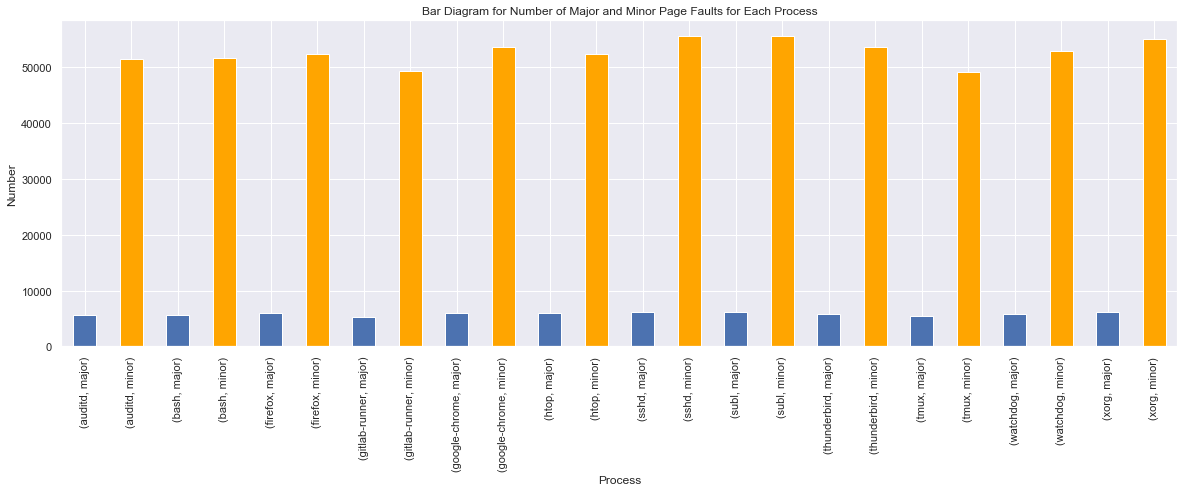

In [15]:
# Part B.c
plt.figure(figsize=(20,6))
df_clean.groupby(['proc_name','major_minor']).size().plot.bar(color=['b','orange'])
plt.xlabel('Process')
plt.ylabel('Number')
plt.title('Bar Diagram for Number of Major and Minor Page Faults for Each Process')
plt.show()

## Part B.d

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000021818F3BCF8>,
      dtype=object)

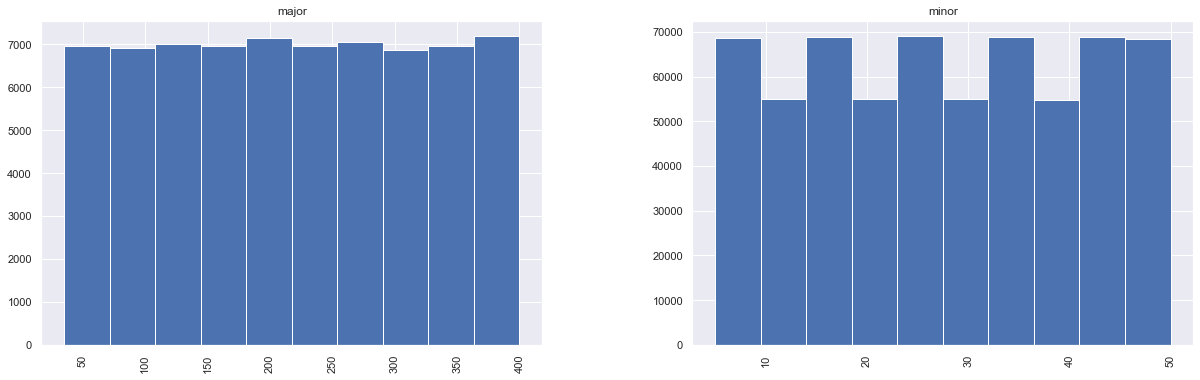

In [16]:
# Part B.d
df_clean['resolve_time'].hist(by=df_clean['major_minor'], figsize=(20,6))
# plt.show()

In [17]:
# calculate the mean of the time to resolve page faults
print('Mean of the time to resolve page faults\n')
print(df_clean.groupby(['proc_name','major_minor']).mean()['resolve_time'])

Mean of the time to resolve page faults

proc_name      major_minor
auditd         major          217.744957
               minor           27.520375
bash           major          217.933310
               minor           27.441138
firefox        major          220.677850
               minor           27.571360
gitlab-runner  major          213.840484
               minor           27.374746
google-chrome  major          218.564163
               minor           27.508144
htop           major          218.407320
               minor           27.427236
sshd           major          216.405321
               minor           27.506795
subl           major          215.434655
               minor           27.445493
thunderbird    major          220.438450
               minor           27.487018
tmux           major          218.882986
               minor           27.447289
watchdog       major          217.280824
               minor           27.599203
xorg           major          

In [18]:
# calculate the standare deviation of the time to resolve page faults
print('Standard deviation of the time to resolve page faults\n')
print(df_clean.groupby(['proc_name','major_minor']).std()['resolve_time'])

Standard deviation of the time to resolve page faults

proc_name      major_minor
auditd         major          105.359066
               minor           13.286257
bash           major          105.217991
               minor           13.274842
firefox        major          104.520439
               minor           13.276758
gitlab-runner  major          106.110610
               minor           13.263701
google-chrome  major          104.980363
               minor           13.230826
htop           major          104.727800
               minor           13.277471
sshd           major          105.368912
               minor           13.299934
subl           major          105.697540
               minor           13.255274
thunderbird    major          107.001650
               minor           13.252948
tmux           major          105.851619
               minor           13.276518
watchdog       major          105.421466
               minor           13.269930
xorg           m

# Part C: Making Predictions

## Part C.a

In [19]:
# Part C.a
print('Calculate the priors for all the classes in fraction\n')
print(df_clean.groupby('proc_name').size()/df_clean.shape[0])

Calculate the priors for all the classes in fraction

proc_name
auditd           0.081370
bash             0.081715
firefox          0.082941
gitlab-runner    0.077611
google-chrome    0.084801
htop             0.082962
sshd             0.087825
subl             0.087860
thunderbird      0.084512
tmux             0.077779
watchdog         0.083724
xorg             0.086901
dtype: float64


## Part C.b

In [20]:
# Part C.b
# calculate P(Major|Class)*P(Class)
posterior_prob_b = (df_clean.groupby(['proc_name','major_minor']).size()/df_clean.groupby(['proc_name']).size())*(df_clean.groupby('proc_name').size()/df_clean.shape[0])
posterior_prob_b

proc_name      major_minor
auditd         major          0.008112
               minor          0.073258
bash           major          0.008129
               minor          0.073585
firefox        major          0.008525
               minor          0.074416
gitlab-runner  major          0.007529
               minor          0.070082
google-chrome  major          0.008449
               minor          0.076351
htop           major          0.008398
               minor          0.074564
sshd           major          0.008664
               minor          0.079160
subl           major          0.008721
               minor          0.079139
thunderbird    major          0.008334
               minor          0.076178
tmux           major          0.007795
               minor          0.069984
watchdog       major          0.008355
               minor          0.075368
xorg           major          0.008649
               minor          0.078253
dtype: float64

In [21]:
print('Largest posterior probability by MAP given that the page fault was major: ', posterior_prob_b.groupby('major_minor').max()['major'])
# Based on the largest posterior probability calculated by MAP
# The page fault is most likely caused by process subl.

Largest posterior probability by MAP given that the page fault was major:  0.008721128780721026


## Part C.c

In [22]:
# Part C.c
# calculate P(R|Class)*P(Class)
posterior_prob_c = (df_clean.groupby(['proc_name','rw']).size()/df_clean.groupby(['proc_name']).size())*(df_clean.groupby('proc_name').size()/df_clean.shape[0])
posterior_prob_c

proc_name      rw
auditd         R     0.056836
               W     0.024534
bash           R     0.057059
               W     0.024655
firefox        R     0.058147
               W     0.024795
gitlab-runner  R     0.054376
               W     0.023235
google-chrome  R     0.059262
               W     0.025539
htop           R     0.058202
               W     0.024760
sshd           R     0.061341
               W     0.026484
subl           R     0.061401
               W     0.026459
thunderbird    R     0.059295
               W     0.025217
tmux           R     0.054592
               W     0.023187
watchdog       R     0.058699
               W     0.025025
xorg           R     0.060850
               W     0.026051
dtype: float64

In [23]:
print('Largest posterior probability by MAP given that the page fault came from a read access: ', posterior_prob_c.groupby('rw').max()['R'])
# Based on the largest posterior probability calculated by MAP
# The page fault is most likely caused by process subl .

Largest posterior probability by MAP given that the page fault came from a read access:  0.061400787733217985


## Part C.d

In [24]:
# Part C.d

# Naïve Bayes model could be used for classifying the process given information about two distinct features, 
# because it is reasonable and intuitive to assume these two features are independent of each other given 
# certain process type. Besides, Naïve Bayes model can be used as a classifier.